## Setup

In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 7.4 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import time
import torch
import torchmetrics
import torchvision
from torchvision import transforms
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import numpy as np
from torch.utils.data import random_split
from torch.autograd import Variable
from matplotlib import pyplot as plt
import pandas as pd
#from ptflops import get_model_complexity_info

#Make sure we are running on the
print(torch.cuda.is_available())
# Storing ID of current CUDA device
if torch.cuda.is_available():
  cuda_id = torch.cuda.current_device()
  print(torch.cuda.get_device_name(cuda_id))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
NVIDIA A100-SXM4-40GB
cuda


In [3]:
#define training fucntion
def train(model, train_loader, val_loader, num_epochs, optimizer, criterion):
  count = 0
  for epoch in range(num_epochs):
      for images, labels in train_loader:
          model.train()

          # Forward pass 
          outputs = model(images)
          labels = torch.eye(10)[labels]
          train_loss = criterion(outputs, labels)

          # Initializing a gradient as 0 so there is no mixing of gradient among the batches
          optimizer.zero_grad()    
          # Propagating the error backward
          train_loss.backward()
          # Optimizing the parameters
          optimizer.step()

          # calculate the accuracy
          accuracy.update(outputs, labels)
          
      final_accuracy_train = accuracy.compute()         
      train_accuracy_list.append(final_accuracy_train)
      train_loss_list.append(train_loss)

      for images, labels in val_loader:
          model.eval()
          labels = torch.eye(10)[labels]
          # Forward pass 
          with torch.no_grad():
            outputs = model(images)
          loss_val = criterion(outputs, labels)

          #calculate the accuracy
          accuracy.update(outputs, labels)

      final_accuracy_val = accuracy.compute()    
      val_accuracy_list.append(final_accuracy_val)
      val_loss_list.append(loss_val)
      print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss}, Train Acc: {final_accuracy_train}, ValidationLoss: {loss_val}, Validation Acc: {final_accuracy_val}')     
      accuracy.reset()

## Loading CIFAR10

In [4]:
transform= transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
batch_size = 20

# Create the data loaders
train_loader = DataLoader(cifar_trainset, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(cifar_testset, batch_size=batch_size, shuffle = False)

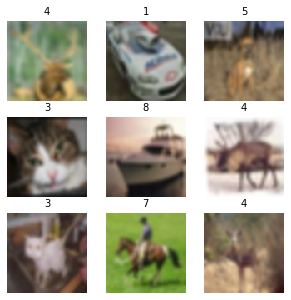

In [6]:
#visualize a few images from the data loader
import matplotlib.pyplot as plt

unnormalize = transforms.Normalize((-1.0, -1.0, -1.0), (2.0, 2.0, 2.0))

images, labels = next(iter(train_loader))

fig, axs = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axs.flat):
    # Unnormalize the image
    image = unnormalize(images[i])
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(labels[i].item(), fontsize=10)
    ax.axis('off')

plt.show()

## Problem 1 - a

In [ ]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [ ]:
class VGG(nn.Module):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
      
    def forward(self, x):
      x = self.net(x)
      return x

In [ ]:
model = VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)))
print(model)

VGG(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): LazyConv2d(0, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
#define params
num_epochs = 5
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.1)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/5], Loss: 2.3409273624420166, Train Acc: 0.4777899980545044, ValidationLoss: 2.3045811653137207, Validation Acc: 0.5214916467666626
Epoch [2/5], Loss: 2.2187721729278564, Train Acc: 0.49532800912857056, ValidationLoss: 2.3420279026031494, Validation Acc: 0.5494400262832642
Epoch [3/5], Loss: 3.813683032989502, Train Acc: 0.5817700028419495, ValidationLoss: 2.2689261436462402, Validation Acc: 0.5948083400726318
Epoch [4/5], Loss: 2.338909864425659, Train Acc: 0.5330359935760498, ValidationLoss: 2.272956132888794, Validation Acc: 0.4741966724395752
Epoch [5/5], Loss: 2.288604974746704, Train Acc: 0.5704560279846191, ValidationLoss: 2.403075695037842, Validation Acc: 0.5853800177574158


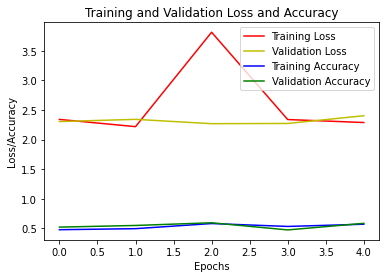

In [ ]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]
vallosses= [ loss.detach().numpy() for loss in val_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

## Problem 1 - b

In [ ]:
#build VGG-16
model = VGG(arch=((2, 64), (2, 128), (3, 256), (3, 512), (3, 512)))
print(model)

VGG(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, 

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
#define params
num_epochs = 7
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.1)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/7], Loss: 2.3111324310302734, Train Acc: 0.23680800199508667, ValidationLoss: 2.3246989250183105, Validation Acc: 0.25400665402412415
Epoch [2/7], Loss: 2.297865152359009, Train Acc: 0.23606400191783905, ValidationLoss: 2.3523123264312744, Validation Acc: 0.24005332589149475
Epoch [3/7], Loss: 2.351515293121338, Train Acc: 0.22055600583553314, ValidationLoss: 2.2602944374084473, Validation Acc: 0.24046333134174347
Epoch [4/7], Loss: 2.2916152477264404, Train Acc: 0.22171999514102936, ValidationLoss: 2.3203768730163574, Validation Acc: 0.2281000018119812
Epoch [5/7], Loss: 2.284186601638794, Train Acc: 0.2065960019826889, ValidationLoss: 2.3389947414398193, Validation Acc: 0.18883000314235687
Epoch [6/7], Loss: 2.3471591472625732, Train Acc: 0.20472800731658936, ValidationLoss: 2.3274967670440674, Validation Acc: 0.22727333009243011


KeyboardInterrupt: ignored

ValueError: ignored

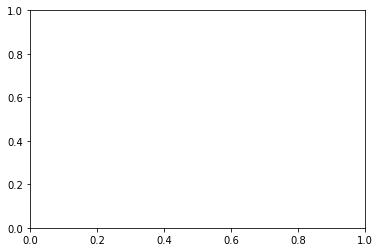

In [ ]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]
vallosses= [ loss.detach().numpy() for loss in val_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

In [ ]:
#build VGG-19
model = VGG(arch=((2, 64), (2, 128), (4, 256), (4, 512), (4, 512)))
print(model)

VGG(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): LazyConv2d(0, 256, kernel

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
#define params
num_epochs = 5
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.1)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/5], Loss: 2.2287254333496094, Train Acc: 0.4943920075893402, ValidationLoss: 2.3879077434539795, Validation Acc: 0.4553266763687134
Epoch [2/5], Loss: 2.309577465057373, Train Acc: 0.48956000804901123, ValidationLoss: 2.2798752784729004, Validation Acc: 0.5579666495323181
Epoch [3/5], Loss: 2.2975974082946777, Train Acc: 0.49856799840927124, ValidationLoss: 2.286705255508423, Validation Acc: 0.4454733431339264
Epoch [4/5], Loss: 2.3282620906829834, Train Acc: 0.4534839987754822, ValidationLoss: 2.325613260269165, Validation Acc: 0.4079033434391022
Epoch [5/5], Loss: 2.316659450531006, Train Acc: 0.5083680152893066, ValidationLoss: 2.4171550273895264, Validation Acc: 0.45364001393318176


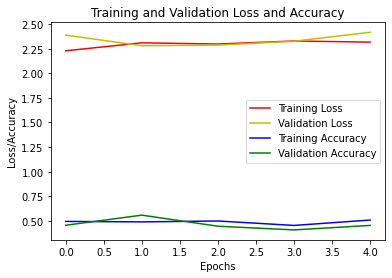

In [ ]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]
vallosses= [ loss.detach().numpy() for loss in val_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

## Problem 2 - a

In [7]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [8]:
class GoogleNet(nn.Module):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
    def b2(self):
      return nn.Sequential(
          nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
          nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
    def b3(self):
      return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                          Inception(128, (128, 192), (32, 96), 64),
                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
    def b4(self):
      return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                          Inception(160, (112, 224), (24, 64), 64),
                          Inception(128, (128, 256), (24, 64), 64),
                          Inception(112, (144, 288), (32, 64), 64),
                          Inception(256, (160, 320), (32, 128), 128),
                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
    def b5(self):
      return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                          Inception(384, (192, 384), (48, 128), 128),
                          nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
    
    def __init__(self, lr=0.1, num_classes=10):
      super(GoogleNet, self).__init__()
      self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(), self.b5(), nn.LazyLinear(num_classes))

    def forward(self, x):
        x = self.net(x)
        return x

In [9]:
model = GoogleNet()
print(model)

GoogleNet(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Inception(
        (b1_1): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
        (b2_1): LazyConv2d(0, 96, kernel_size=(1, 1), stride=(1, 1))
        (b2_2): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (b3_1): LazyConv2d(0, 16, kernel_size=(1, 1), stride=(1, 1))
        (b3_2): LazyConv2d(0, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (b4_1): MaxPool2d(kernel_size=3, s

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [12]:
#define params
num_epochs =5
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.1)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [13]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/5], Loss: 2.292693614959717, Train Acc: 0.5439519882202148, ValidationLoss: 2.280888319015503, Validation Acc: 0.5632933378219604
Epoch [2/5], Loss: 2.2835991382598877, Train Acc: 0.5374600291252136, ValidationLoss: 2.267658233642578, Validation Acc: 0.5445500016212463
Epoch [3/5], Loss: 2.293254852294922, Train Acc: 0.5539720058441162, ValidationLoss: 2.329414129257202, Validation Acc: 0.5449766516685486
Epoch [4/5], Loss: 2.2659993171691895, Train Acc: 0.5307040214538574, ValidationLoss: 2.3690216541290283, Validation Acc: 0.5255866646766663
Epoch [5/5], Loss: 2.3036444187164307, Train Acc: 0.5190079808235168, ValidationLoss: 2.3252012729644775, Validation Acc: 0.5158399939537048


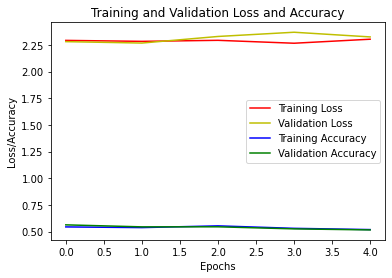

In [14]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]
vallosses= [ loss.detach().numpy() for loss in val_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

## Problem 2 - b

In [19]:
class BNLeNet(nn.Module):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))
        
    def forward(self, x):
        x = self.net(x)
        return x

In [20]:
model = BNLeNet()
print(model)

BNLeNet(
  (net): Sequential(
    (0): LazyConv2d(0, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): LazyConv2d(0, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Sigmoid()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): LazyLinear(in_features=0, out_features=120, bias=True)
    (10): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
    (12): LazyLinear(in_features=0, out_features=84, bias=True)
    (13): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Sigmoid()
    (15): LazyLinear(in_features=0, out_features=10, bias=True)
  )
)


In [21]:
#define params
num_epochs = 5
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.1)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [22]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/5], Loss: 1.4429683685302734, Train Acc: 0.6142299771308899, ValidationLoss: 1.4317682981491089, Validation Acc: 0.6260583400726318
Epoch [2/5], Loss: 1.2442660331726074, Train Acc: 0.6947439908981323, ValidationLoss: 1.400903582572937, Validation Acc: 0.7002000212669373
Epoch [3/5], Loss: 1.468349814414978, Train Acc: 0.7316740155220032, ValidationLoss: 1.064528465270996, Validation Acc: 0.7332883477210999
Epoch [4/5], Loss: 1.693575143814087, Train Acc: 0.7538660168647766, ValidationLoss: 1.0532071590423584, Validation Acc: 0.7571616768836975
Epoch [5/5], Loss: 1.168652057647705, Train Acc: 0.7724940180778503, ValidationLoss: 1.2739067077636719, Validation Acc: 0.7750599980354309


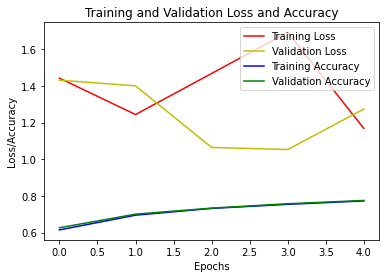

In [23]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]
vallosses= [ loss.detach().numpy() for loss in val_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

## Problem 3 - a

In [24]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [34]:
class ResNet(nn.Module):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels))
        return nn.Sequential(*blk)

    def __init__(self, arch, lr=0.1, num_classes=10):
        super(ResNet, self).__init__()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))
        
    def forward(self, x):
        x = self.net(x)
        return x

In [35]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)), lr, num_classes)

In [36]:
model = ResNet18()
print(model)

ResNet18(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (b2): Sequential(
      (0): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): LazyBatchNorm2d(0, eps=1e-05, momentu

In [37]:
#define params
num_epochs = 5
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.1)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [38]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/5], Loss: 2.305701494216919, Train Acc: 0.348798006772995, ValidationLoss: 2.274069309234619, Validation Acc: 0.3606649935245514
Epoch [2/5], Loss: 2.2878284454345703, Train Acc: 0.35121598839759827, ValidationLoss: 2.304396152496338, Validation Acc: 0.34934666752815247
Epoch [3/5], Loss: 2.291713237762451, Train Acc: 0.33535999059677124, ValidationLoss: 2.2923240661621094, Validation Acc: 0.33613333106040955
Epoch [4/5], Loss: 2.349691390991211, Train Acc: 0.33990800380706787, ValidationLoss: 2.349512815475464, Validation Acc: 0.33992332220077515
Epoch [5/5], Loss: 2.3336193561553955, Train Acc: 0.3191800117492676, ValidationLoss: 2.3756167888641357, Validation Acc: 0.3359833359718323


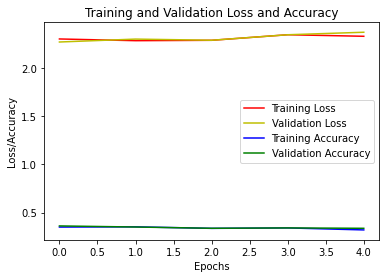

In [39]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]
vallosses= [ loss.detach().numpy() for loss in val_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

## Problem 3 - b

In [ ]:
class ResNet26(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__((), lr, num_classes)

In [ ]:
model = ResNet26()
print(model)

In [ ]:
#define params
num_epochs = 5
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.1)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

In [ ]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]
vallosses= [ loss.detach().numpy() for loss in val_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

In [ ]:
class ResNet32(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__((), lr, num_classes)

In [ ]:
model = ResNet32()
print(model)

In [ ]:
#define params
num_epochs = 5
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.1)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

In [ ]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]
vallosses= [ loss.detach().numpy() for loss in val_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()